# Import Libraries

In [49]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd

import os
import time
import gc

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, log_loss, f1_score, precision_score, recall_score
from sklearn.ensemble import ExtraTreesClassifier

from lightgbm import LGBMClassifier

import random

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Augmentation

In [50]:
test2 = pd.read_csv('/content/drive/MyDrive/data/appended_new_opcodes.csv')
test = pd.read_csv('/content/drive/MyDrive/data/appended_result_embed.csv')
test.head()

,ID,Family,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,01kcPWA9K2BOxQeS5Rju,1,-0.426271,1.495527,0.442969,-1.784287,0.687246,-0.163921,-0.821085,-0.767919,...,-0.816768,-1.232931,0.312494,0.956752,0.134952,0.596190,-0.748863,-0.692929,1.376552,-0.300369
1,04EjIdbPV5e1XroFOpiN,1,-0.429474,1.381561,0.241621,-0.654752,0.227177,-0.599185,-0.663230,-0.332880,...,-0.419219,-0.413807,-0.152669,0.227969,0.036689,1.294578,-0.139708,-0.803917,1.071521,-0.173929
2,05EeG39MTRrI6VY21DPd,1,-0.386531,1.551624,0.240367,-0.513145,0.496933,-0.666564,-0.377270,-0.464443,...,-0.594439,-0.584387,-0.087269,0.306046,0.010809,1.528025,-0.402952,-0.582781,1.199226,-0.128288
3,05rJTUWYAKNegBk2wE8X,1,-0.355359,1.305468,0.119359,-0.908725,0.154450,-0.639722,-0.896534,-0.308548,...,-0.354546,-0.347760,-0.217605,0.317562,0.046546,1.289890,-0.135289,-0.718038,1.174416,-0.230006
4,0AnoOZDNbPXIr2MRBSCJ,1,-0.193080,1.316853,-0.107708,-0.632932,0.209633,-0.560659,-0.372401,-0.302188,...,-0.367623,-0.139803,-0.225833,-0.011875,0.134646,1.751419,-0.285946,-0.762208,1.015983,0.295280


In [51]:
test2= pd.DataFrame(test['ID']).merge(test2, on='ID').reset_index(drop = True)
test2

,ID,Opcodes,Family
0,01kcPWA9K2BOxQeS5Rju,push push mov push mov sub mov push push lea m...,1
1,04EjIdbPV5e1XroFOpiN,push push mov push mov mov mov lea push retn m...,1
2,05EeG39MTRrI6VY21DPd,push mov mov test mov jz push call mov test jz...,1
3,05rJTUWYAKNegBk2wE8X,cmp jnz test jnz retn mov push mov mov push mo...,1
4,0AnoOZDNbPXIr2MRBSCJ,push mov sub mov and and push push mov cmp mov...,1
...,...,...,...
10863,KFrZ0Lop1WDGwUtkusCi,push mov sub retn push mov sub and adc or push...,9
10864,kg24YRJTB8DNdKMXpwOH,push mov sub adc and xor push pop lea cmp jz t...,9
10865,kG29BLiFYPgWtpb350sO,or push mov sub add sub or lea test ja test ja...,9
10866,kGITL4OJxYMWEQ1bKBiP,aAm out out out out out out push mov sub mov a...,9


In [52]:
vectorizer = TfidfVectorizer(max_features=99)
tf_encs = vectorizer.fit_transform(test2['Opcodes'])
tf_encs = tf_encs.toarray()
Xx = pd.DataFrame(tf_encs)

In [53]:
test= test.reset_index(drop = True)
test['Family'] = test['Family'] - 1
test.head()

,ID,Family,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,01kcPWA9K2BOxQeS5Rju,0,-0.426271,1.495527,0.442969,-1.784287,0.687246,-0.163921,-0.821085,-0.767919,...,-0.816768,-1.232931,0.312494,0.956752,0.134952,0.596190,-0.748863,-0.692929,1.376552,-0.300369
1,04EjIdbPV5e1XroFOpiN,0,-0.429474,1.381561,0.241621,-0.654752,0.227177,-0.599185,-0.663230,-0.332880,...,-0.419219,-0.413807,-0.152669,0.227969,0.036689,1.294578,-0.139708,-0.803917,1.071521,-0.173929
2,05EeG39MTRrI6VY21DPd,0,-0.386531,1.551624,0.240367,-0.513145,0.496933,-0.666564,-0.377270,-0.464443,...,-0.594439,-0.584387,-0.087269,0.306046,0.010809,1.528025,-0.402952,-0.582781,1.199226,-0.128288
3,05rJTUWYAKNegBk2wE8X,0,-0.355359,1.305468,0.119359,-0.908725,0.154450,-0.639722,-0.896534,-0.308548,...,-0.354546,-0.347760,-0.217605,0.317562,0.046546,1.289890,-0.135289,-0.718038,1.174416,-0.230006
4,0AnoOZDNbPXIr2MRBSCJ,0,-0.193080,1.316853,-0.107708,-0.632932,0.209633,-0.560659,-0.372401,-0.302188,...,-0.367623,-0.139803,-0.225833,-0.011875,0.134646,1.751419,-0.285946,-0.762208,1.015983,0.295280


# Utility Functions

In [54]:
def train_model(data_loader, model, optimizer, device):
  """
  This function does training for one epoch
  :param data_loader: this is the pytorch dataloader
  :param model: pytorch model
  :param optimizer: optimizer, for e.g. adam, sgd, etc
  :param device: cuda/cpu
  """
  # put the model in train mode
  model.train()
  # scheduler = get_scheduler(optimizer, 'CosineAnnealingWarmRestarts')
  # go over every batch of data in data loader
  for data in tqdm(data_loader):
    # remember, we have image and targets
    # in our dataset class
    inputs = data["X"]
    targets = data["targets"]

    # move inputs/targets to cuda/cpu device
    inputs = inputs.to(device, dtype=torch.float)
    targets = targets.to(device, dtype=torch.float)

    # zero grad the optimizer
    optimizer.zero_grad()
    #do the forward step of model
    outputs = model(inputs)
    # calculate loss

    loss = nn.CrossEntropyLoss()(outputs,targets.long())
    # backward step the loss
    loss.backward()
    # step optimizer
    optimizer.step()
    # if you have a scheduler, you either need to
    # step it here or you have to step it after
    # the epoch. here, we are not using any learning
    # rate scheduler
  # scheduler.step()

def evaluate_model(data_loader, model, device):
  """
  This function does evaluation for one epoch
  :param data_loader: this is the pytorch dataloader
  :param model: pytorch model
  :param device: cuda/cpu
  """
  # put model in evaluation mode
  model.eval()

  # init lists to store targets and outputs
  final_targets = []
  final_outputs = []

  # we use no_grad context
  with torch.no_grad():
    for data in tqdm(data_loader):
      inputs = data["X"]
      targets = data["targets"]
      inputs = inputs.to(device, dtype=torch.float)
      targets = targets.to(device, dtype=torch.float)

      # do the forward step to generate prediction
      output = model(inputs)

      # convert targets and outputs to lists
      targets = targets.detach().cpu().numpy().tolist()
      output = output.detach().cpu().numpy().tolist()

      # extend the original list
      final_targets.extend(targets)
      final_outputs.extend(output)

  # return final output and final targets
  return final_outputs, final_targets

import os
def save_checkpoint(model, optimizer, path):
    if not os.path.exists(os.path.dirname(path)):
        print("Creating directories on path: `{}`".format(path))
        os.makedirs(os.path.dirname(path))

    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }, path)


def load_checkpoint(model, path):
    checkpoint = torch.load(path)

    model.load_state_dict(checkpoint["model_state_dict"])

    optimizer = torch.optim.Adam(model.parameters())
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    return model, optimizer


def save_model(model, path):
  if not os.path.exists(os.path.dirname(path)):
      print("Creating directories on path: `{}`".format(path))
      os.makedirs(os.path.dirname(path))

  torch.save({
      "model_state_dict": model.state_dict(),
  }, path)


def load_model(model, path):
  restore_dict = torch.load(path)

  model.load_state_dict(restore_dict["model_state_dict"])
  model.eval()

  return model

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

def get_scheduler(optimizer, scheduler):
    if scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4, verbose=True, eps=1e-6)
    elif scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6, last_epoch=-1)
    elif scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)
    return scheduler

In [55]:
LSTM_UNITS = 128
GRU_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
MAX_LEN = 100

In [56]:
class NeuralNet(nn.Module):
    def __init__(self, input_shape, num_aux_targets):
        super(NeuralNet, self).__init__()
        self.lstm = nn.LSTM(input_shape, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(input_shape, GRU_UNITS, bidirectional=True, batch_first=True)

        self.linear1 = nn.Linear(LSTM_UNITS*2, DENSE_HIDDEN_UNITS)
        self.linear2 = nn.Linear(GRU_UNITS*2, DENSE_HIDDEN_UNITS)

        self.attention = nn.Sequential(
            nn.Linear(DENSE_HIDDEN_UNITS, 256),
            nn.Tanh(),
            nn.Linear(256, 1),
            nn.Softmax(dim=1)
        )


        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        # self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)

    def forward(self, x):
        x = x.view((-1,1,100))
        h_lstm, _ = self.lstm(x)
        h_gru, _ = self.gru(x)

        h_lstm = h_lstm.squeeze()
        h_gru = h_gru.squeeze()

        # global average pooling
        # avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        # max_pool, _ = torch.max(h_lstm2, 1)

        # h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = F.relu(self.linear1(h_lstm))
        h_conc_linear2  = F.relu(self.linear2(h_gru))

        hidden = (h_conc_linear1 + h_conc_linear2)/2

        weights = self.attention(hidden)

        context_vector = weights * hidden

        # print(context_vector.shape)
        # print(weights.shape)
        # print(hidden.shape)

        results = self.linear_out(context_vector)

        return nn.Softmax(dim=1)(results)

In [57]:
class Dataset:
  def __init__(self, X, targets):
    self.X = X
    self.target = targets

  def __len__(self):
    return len(self.X)

  def __getitem__(self, item):
    X = self.X[item, :]
    target = self.target[item]
    return {
      "X": torch.tensor(X, dtype=torch.float),
      "targets": torch.tensor(target, dtype=torch.float)
    }

In [58]:
epochs = 50
device = 'cpu'

In [59]:
def inference(data_loader, model, device):
  model.eval()

  final_outputs = []

  with torch.no_grad():
    for data in tqdm(data_loader):
      inputs = data["X"]

      inputs = inputs.to(device, dtype=torch.float)

      output = model(inputs)

      # convert targets and outputs to lists
      output = output.detach().cpu().numpy().tolist()

      # extend the original list
      final_outputs.extend(output)

  # return final output and final targets
  return final_outputs

# Feature Importance Based Attack

In [60]:
import pandas as pd
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

# Extract features and labels
features = test.drop(['ID', 'Family'], axis=1)  # Adjust columns as needed
labels = test['Family']

# Step 1: Get feature (S)
selected_features = features.columns  # Placeholder for feature selection

# Step 2: X - f_classif (ANOVA F-value between label/feature for classification tasks)
f_scores, _ = f_classif(features, labels)

# Step 3: IG - Information Gain
ig_scores = mutual_info_classif(features, labels)

# Step 4: S - FDE feature selection algorithm
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features, labels)
s_scores = rf.feature_importances_

# Step 5: Combine scores (C)
combined_scores = (f_scores + ig_scores + s_scores) / 3

# Step 6: Get top 10 features based on combined score
top_features_indices = combined_scores.argsort()[-20:][::-1]
top_features = selected_features[top_features_indices]

# Print or use top features as needed
print("Top 20 features:", top_features)


Top 20 features: Index(['40', '15', '43', '23', '90', '20', '13', '26', '18', '8', '63', '96',
       '28', '79', '93', '52', '61', '50', '74', '62'],
      dtype='object')


In [70]:
perturb= 0.25
for feature in top_features:
    test[feature] += perturb

In [62]:
class TestDataset:
  def __init__(self, X):
    self.X = X

  def __len__(self):
    return len(self.X)

  def __getitem__(self, item):
    X = self.X[item, :]
    return {
      "X": torch.tensor(X, dtype=torch.float),
    }

In [71]:
test_dataset = TestDataset(test.iloc[:,2:].values)
test_loader = torch.utils.data.DataLoader(
  test_dataset, batch_size=64, shuffle=False, num_workers=4
)

In [64]:
test2['Opcodes'] = test2['Opcodes'].apply(lambda x: str(x).replace(',',' '))
test_encs = vectorizer.transform(test2['Opcodes'])
test_encs = test_encs.toarray()
test_encs = pd.DataFrame(test_encs)

In [65]:
models_nn = [
             '/content/drive/MyDrive/models/models_nn/model_fold0_49.pth',
             '/content/drive/MyDrive/models/models_nn/model_fold1_49.pth',
             '/content/drive/MyDrive/models/models_nn/model_fold2_37.pth',
             '/content/drive/MyDrive/models/models_nn/model_fold3_47.pth',
             '/content/drive/MyDrive/models/models_nn/model_fold4_45.pth'
]
models_xgb = [
              '/content/drive/MyDrive/models/models_xgb/xgb_fold0.b5',
              '/content/drive/MyDrive/models/models_xgb/xgb_fold1.b5',
              '/content/drive/MyDrive/models/models_xgb/xgb_fold2.b5',
              '/content/drive/MyDrive/models/models_xgb/xgb_fold3.b5',
              '/content/drive/MyDrive/models/models_xgb/xgb_fold4.b5'
]

models_lgbm = [
               '/content/drive/MyDrive/models/models_lgbm/lgbm_fold0.b5',
               '/content/drive/MyDrive/models/models_lgbm/lgbm_fold1.b5',
               '/content/drive/MyDrive/models/models_lgbm/lgbm_fold2.b5',
               '/content/drive/MyDrive/models/models_lgbm/lgbm_fold3.b5',
               '/content/drive/MyDrive/models/models_lgbm/lgbm_fold4.b5'
]

models_log=[
               '/content/drive/MyDrive/models/models_log/logistic_reg_fold0.b5',
               '/content/drive/MyDrive/models/models_log/logistic_reg_fold1.b5',
               '/content/drive/MyDrive/models/models_log/logistic_reg_fold2.b5',
               '/content/drive/MyDrive/models/models_log/logistic_reg_fold3.b5',
               '/content/drive/MyDrive/models/models_log/logistic_reg_fold0.b5'
]

models_svm=[
               '/content/drive/MyDrive/models/models_svm/svm_fold0.b5',
               '/content/drive/MyDrive/models/models_svm/svm_fold1.b5',
               '/content/drive/MyDrive/models/models_svm/svm_fold2.b5',
               '/content/drive/MyDrive/models/models_svm/svm_fold3.b5',
               '/content/drive/MyDrive/models/models_svm/svm_fold4.b5'
]

models_rf=[
               '/content/drive/MyDrive/models/models_rf/random_forest_fold0.b5',
               '/content/drive/MyDrive/models/models_rf/random_forest_fold1.b5',
               '/content/drive/MyDrive/models/models_rf/random_forest_fold2.b5',
               '/content/drive/MyDrive/models/models_rf/random_forest_fold3.b5',
               '/content/drive/MyDrive/models/models_rf/random_forest_fold4.b5'
]

In [66]:
def get_final_test_acc(x,y):
  count=0
  for i in range(len(x)):
    if x[i]==y[i]:
      count+=1
  return count

In [72]:
model1_preds_all = []
model2_preds_all = []
model3_preds_all = []
model4_preds_all = []


test_accs=[]

for model_nn, model_lgbm, model_xgb, model_log, model_svm, model_rf in zip(models_nn, models_lgbm, models_xgb, models_log, models_svm, models_rf):
  model = NeuralNet(100, 9).to(device)
  model, _ = load_checkpoint(model, model_nn)
  model_xgb = pickle.load(open(model_xgb, 'rb'))
  model_lgbm = pickle.load(open(model_lgbm, 'rb'))
  model_log = pickle.load(open(model_log, 'rb'))
  model_svm = pickle.load(open(model_svm, 'rb'))
  model_rf = pickle.load(open(model_rf, 'rb'))

  nn_preds = inference(test_loader, model, device)
  lgbm_preds = model_lgbm.predict_proba(test_encs.values)
  xgb_preds = model_xgb.predict_proba(test_encs.values)
  log_preds = model_log.predict_proba(test_encs.values)
  svm_preds = model_svm.predict_proba(test_encs.values)
  rf_preds = model_rf.predict_proba(test_encs.values)

  model1_preds = np.array(nn_preds) * 0.33 + lgbm_preds * 0.33 + xgb_preds * 0.33
  model2_preds = np.array(nn_preds) * 0.50 + log_preds * 0.50
  model3_preds=np.array(nn_preds) * 0.50 + svm_preds * 0.50
  model4_preds = np.array(nn_preds) * 0.50 + rf_preds * 0.50
  model5_preds = lgbm_preds * 0.5 + xgb_preds * 0.5
  model6_preds =log_preds
  model7_preds =svm_preds
  model8_preds =rf_preds

  model1_preds_all.append(model1_preds)
  model2_preds_all.append(model2_preds)
  model3_preds_all.append(model3_preds)
  model4_preds_all.append(model4_preds)


model1_final_preds=  pd.DataFrame(np.array(model1_preds_all).mean(axis=0))
model1_final_preds = model1_final_preds.idxmax(axis=1)
model1_final_test_acc = (get_final_test_acc(test['Family'],model1_final_preds))/len(model1_final_preds)
test_accs.append(model1_final_test_acc)
print("\n\nTest Accuracy for Model 1 (SEA + XGBoost + LGBM) = ",model1_final_test_acc)


model2_final_preds=  pd.DataFrame(np.array(model2_preds_all).mean(axis=0))
model2_final_preds = model2_final_preds.idxmax(axis=1)
model2_final_test_acc = (get_final_test_acc(test['Family'],model2_final_preds))/len(model2_final_preds)
test_accs.append(model2_final_test_acc)
print("\n\nTest Accuracy for Model 2 (SEA + Logistic Regression) = ",model2_final_test_acc)

model3_final_preds=  pd.DataFrame(np.array(model3_preds_all).mean(axis=0))
model3_final_preds = model3_final_preds.idxmax(axis=1)
model3_final_test_acc = (get_final_test_acc(test['Family'],model3_final_preds))/len(model3_final_preds)
test_accs.append(model3_final_test_acc)
print("\n\nTest Accuracy for Model 3 (SEA + SVM) = ",model3_final_test_acc)


model4_final_preds=  pd.DataFrame(np.array(model4_preds_all).mean(axis=0))
model4_final_preds = model4_final_preds.idxmax(axis=1)
model4_final_test_acc = (get_final_test_acc(test['Family'],model4_final_preds))/len(model4_final_preds)
test_accs.append(model4_final_test_acc)
print("\n\nTest Accuracy for Model 4 (SEA + Random Forest) = ",model4_final_test_acc)



100%|██████████| 170/170 [00:01<00:00, 95.26it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:02<00:00, 61.26it/s]


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 96.96it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 93.93it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:02<00:00, 78.06it/s] 


[LightGBM] [Warning] Unknown parameter: silent


Test Accuracy for Model 1 (SEA + XGBoost + LGBM) =  0.895841001104159


Test Accuracy for Model 2 (SEA + Logistic Regression) =  0.8740338608759661


Test Accuracy for Model 3 (SEA + SVM) =  0.8973132131026867


Test Accuracy for Model 4 (SEA + Random Forest) =  0.9135995583364005


In [68]:
model_names=['Original: SEA + XGboost + LGBM','SEA + Logistic Regression','SEA + SVM','SEA + Random Forest']

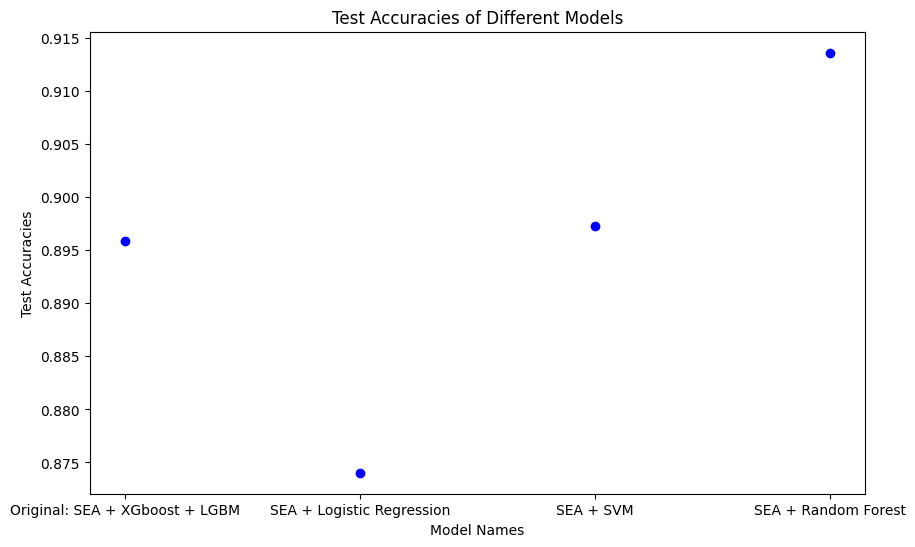

In [74]:
plt.figure(figsize=(10, 6))
# Create a scatter plot
plt.scatter(model_names, test_accs, color='blue')

# Add labels and title
plt.xlabel('Model Names')
plt.ylabel('Test Accuracies')
plt.title('Test Accuracies of Different Models')

# Show the plot
plt.show()


# Adversarial Retraining Defense

In [80]:
orig_test=pd.read_csv('/content/drive/MyDrive/data/result_embed.csv')
orig_test['Family'] = orig_test['Family'] - 1
orig_test2=pd.read_csv('/content/drive/MyDrive/data/dataset.csv')
orig_test2= pd.DataFrame(orig_test['ID']).merge(orig_test2, on='ID').reset_index(drop = True)
orig_test2['Opcodes'] = orig_test2['Opcodes'].apply(lambda x: str(x).replace(',',' '))
orig_test2.drop(columns=['Family'], inplace=True)


In [81]:
final_embed=pd.concat([orig_test, test], ignore_index=True)
final_op=pd.concat([orig_test2, test2], ignore_index=True)

In [77]:
vectorizer = TfidfVectorizer(max_features=99)
tf_encs = vectorizer.fit_transform(final_op['Opcodes'])
tf_encs = tf_encs.toarray()
Xx = pd.DataFrame(tf_encs)

In [82]:
final_embed= final_embed.reset_index(drop = True)
final_embed.head()

,ID,Family,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,01kcPWA9K2BOxQeS5Rju,0,-0.338611,1.291727,0.118837,-1.118286,0.183966,-0.405247,-0.729886,-0.332307,...,-0.475346,-0.425257,-0.000070,0.276955,0.192112,1.176439,-0.234972,-0.730219,1.071440,-0.091770
1,04EjIdbPV5e1XroFOpiN,0,-0.428330,1.376984,0.234024,-0.627847,0.213055,-0.609343,-0.659496,-0.320076,...,-0.408290,-0.389868,-0.164271,0.207200,0.035918,1.313510,-0.123089,-0.806177,1.062548,-0.169090
2,05EeG39MTRrI6VY21DPd,0,-0.377473,1.542212,0.202506,-0.368294,0.447894,-0.722350,-0.336275,-0.411114,...,-0.553859,-0.478773,-0.139812,0.208929,0.004945,1.640448,-0.340988,-0.576668,1.164637,-0.100652
3,05rJTUWYAKNegBk2wE8X,0,-0.354789,1.304047,0.117015,-0.903091,0.150693,-0.642379,-0.896521,-0.305303,...,-0.351606,-0.341613,-0.220712,0.312799,0.046395,1.294530,-0.131182,-0.718261,1.172608,-0.229033
4,0AnoOZDNbPXIr2MRBSCJ,0,-0.175248,1.296375,-0.155661,-0.533257,0.156963,-0.595596,-0.341953,-0.253579,...,-0.324669,-0.036423,-0.272495,-0.101691,0.137479,1.847042,-0.233596,-0.768067,0.979953,0.340067


In [83]:
# warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, message=".*force_row_wise=true.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*force_col_wise=true.*")




i = 0
fold = 4
logloss_list, f1_list, recall_list, precision_list, accuracy_list = [], [], [], [], []
for tr_in, val_in in StratifiedKFold(n_splits=5, shuffle=True).split(final_embed, final_embed['Family']):
  x_train = final_embed.drop(['ID', 'Family'],axis=1).loc[tr_in, :]
  x_test = final_embed.drop(['ID', 'Family'],axis=1).loc[val_in, :]
  y_train = final_embed.loc[tr_in, 'Family']
  y_test = final_embed.loc[val_in, 'Family']


  xx_train = Xx.loc[tr_in, :]
  xx_test = Xx.loc[val_in, :]


  model = NeuralNet(100, 9).to(device)


  train_dataset = Dataset(
    x_train.values,
    y_train.values
  )
  train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=4
  )


  valid_dataset = Dataset(
    x_test.values,
    y_test.values
  )


  valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=4
  )
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


  lgbm = LGBMClassifier(n_jobs=-1, silent =True)
  xgb = XGBClassifier(n_jobs=-1, verbosity=0)
  logistic_reg = LogisticRegression(max_iter=100)
  svm_classifier = SVC(probability=True)
  random_forest = RandomForestClassifier(n_jobs=-1)


  lgbm.fit(xx_train.values, y_train.values)
  xgb.fit(xx_train.values, y_train.values)
  logistic_reg.fit(xx_train.values, y_train.values)
  svm_classifier.fit(xx_train.values, y_train.values)
  random_forest.fit(xx_train.values, y_train.values)


  pickle.dump(lgbm, open(f'/content/drive/MyDrive/fib_models/fib_models_lgbm/fib_lgbm_fold{i}.b5', 'wb'))
  pickle.dump(xgb, open(f'/content/drive/MyDrive/fib_models/fib_models_xgb/fib_xgb_fold{i}.b5', 'wb'))
  pickle.dump(logistic_reg, open(f'/content/drive/MyDrive/fib_models/fib_models_log/fib_logistic_reg_fold{i}.b5', 'wb'))
  pickle.dump(svm_classifier, open(f'/content/drive/MyDrive/fib_models/fib_models_svm/fib_svm_fold{i}.b5', 'wb'))
  pickle.dump(random_forest, open(f'/content/drive/MyDrive/fib_models/fib_models_rf/fib_random_forest_fold{i}.b5', 'wb'))




  best_logloss = 10
  for epoch in range(epochs):
      train_model(train_loader, model, optimizer, device=device)


      predictions, valid_targets = evaluate_model(
        valid_loader, model, device=device
      )


      lgbm_preds = lgbm.predict_proba(xx_test.values)
      xgb_preds = xgb.predict_proba(xx_test.values)


      predictions = (np.array(predictions) * 0.33 + lgbm_preds * 0.33 + xgb_preds * 0.33)


      logloss = metrics.log_loss(valid_targets, predictions)
      f1 = metrics.f1_score(valid_targets, np.array(predictions).argmax(axis=1), average='micro')
      recall = metrics.recall_score(valid_targets, np.array(predictions).argmax(axis=1), average='micro')
      precision = metrics.precision_score(valid_targets, np.array(predictions).argmax(axis=1), average='micro')
      accuracy = metrics.accuracy_score(valid_targets, np.array(predictions).argmax(axis=1))


      logloss_list.append(logloss)
      f1_list.append(f1)
      recall_list.append(recall)
      precision_list.append(precision)
      accuracy_list.append(accuracy)


      print(
        f"Epoch={epoch} \nValidation: = Logloss: {round(logloss*100,3)} F1: {round(f1*100,3)} Recall: {round(recall*100,3)} Precision: {round(precision*100,3)} Accuracy: {round(accuracy*100,3)}"
      )
      if logloss < best_logloss:
        save_checkpoint(model, optimizer, f'/content/drive/MyDrive/fib_models/fib_models_nn/fib_model_fold{i}_{epoch}.pth')
        best_logloss = logloss
  i += 1



[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23436
[LightGBM] [Info] Number of data points in the train set: 17388, number of used features: 96
[LightGBM] [Info] Start training from score -1.953589
[LightGBM] [Info] Start training from score -1.478274
[LightGBM] [Info] Start training from score -1.306730
[LightGBM] [Info] Start training from score -3.130217
[LightGBM] [Info] Start training from score -5.558843
[LightGBM] [Info] Start training from score -2.671793
[LightGBM] [Info] Start training from score -3.306766
[LightGBM] [Info] Start training from score -2.180288
[LightGBM] [Info] Start training from score -2.373354
[LightGBM] [Warning] No further splits with positive gain, best ga

100%|██████████| 68/68 [00:01<00:00, 41.21it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=0 
Validation: = Logloss: 14.398 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 35.87it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=1 
Validation: = Logloss: 10.218 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 51.21it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=2 
Validation: = Logloss: 9.545 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 52.33it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=3 
Validation: = Logloss: 9.427 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:02<00:00, 32.84it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=4 
Validation: = Logloss: 9.255 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 50.23it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=5 
Validation: = Logloss: 9.448 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 54.19it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=6 
Validation: = Logloss: 9.187 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 38.43it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=7 
Validation: = Logloss: 9.137 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 45.66it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=8 
Validation: = Logloss: 8.884 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 51.12it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=9 
Validation: = Logloss: 9.015 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 50.55it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=10 
Validation: = Logloss: 7.916 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 35.31it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=11 
Validation: = Logloss: 7.541 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 52.39it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=12 
Validation: = Logloss: 7.614 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 53.12it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=13 
Validation: = Logloss: 7.642 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 34.46it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=14 
Validation: = Logloss: 7.482 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 52.12it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=15 
Validation: = Logloss: 7.425 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 52.06it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=16 
Validation: = Logloss: 7.537 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 34.39it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=17 
Validation: = Logloss: 7.632 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 53.25it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=18 
Validation: = Logloss: 7.494 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 52.15it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=19 
Validation: = Logloss: 7.405 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:02<00:00, 33.57it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=20 
Validation: = Logloss: 7.769 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 54.38it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=21 
Validation: = Logloss: 7.488 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 54.37it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=22 
Validation: = Logloss: 7.367 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 35.46it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=23 
Validation: = Logloss: 7.423 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 53.99it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=24 
Validation: = Logloss: 7.229 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 52.57it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=25 
Validation: = Logloss: 7.376 F1: 99.425 Recall: 99.425 Precision: 99.425 Accuracy: 99.425


100%|██████████| 68/68 [00:02<00:00, 30.88it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=26 
Validation: = Logloss: 7.033 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 54.40it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=27 
Validation: = Logloss: 7.051 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 50.83it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=28 
Validation: = Logloss: 6.982 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:02<00:00, 33.35it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=29 
Validation: = Logloss: 7.134 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 52.92it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=30 
Validation: = Logloss: 7.118 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 53.75it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=31 
Validation: = Logloss: 7.006 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:02<00:00, 34.00it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=32 
Validation: = Logloss: 7.054 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 53.43it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=33 
Validation: = Logloss: 7.108 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 53.77it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=34 
Validation: = Logloss: 7.122 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 36.63it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=35 
Validation: = Logloss: 6.974 F1: 99.425 Recall: 99.425 Precision: 99.425 Accuracy: 99.425


100%|██████████| 68/68 [00:01<00:00, 54.20it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=36 
Validation: = Logloss: 7.045 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 53.25it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=37 
Validation: = Logloss: 6.987 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 42.78it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=38 
Validation: = Logloss: 6.896 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 44.24it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=39 
Validation: = Logloss: 7.271 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 54.02it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=40 
Validation: = Logloss: 6.953 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 53.47it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=41 
Validation: = Logloss: 7.129 F1: 99.425 Recall: 99.425 Precision: 99.425 Accuracy: 99.425


100%|██████████| 68/68 [00:01<00:00, 39.24it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=42 
Validation: = Logloss: 6.983 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 53.62it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=43 
Validation: = Logloss: 7.034 F1: 99.425 Recall: 99.425 Precision: 99.425 Accuracy: 99.425


100%|██████████| 68/68 [00:01<00:00, 55.23it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=44 
Validation: = Logloss: 6.964 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 35.82it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=45 
Validation: = Logloss: 6.901 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 53.65it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=46 
Validation: = Logloss: 6.952 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 53.46it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=47 
Validation: = Logloss: 7.015 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 35.94it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=48 
Validation: = Logloss: 7.047 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 54.62it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=49 
Validation: = Logloss: 6.949 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23427
[LightGBM] [Info] Number of data points in the train set: 17389, number of used features: 96
[LightGBM] [Info] Start training from score -1.953646
[LightGBM] [Info] Start training from score -1.478332
[LightGBM] [Info] Start training from score -1.306787
[LightGBM] [Info] Start training from score -3.130275
[LightGBM] [Info] Start training from score -5.544085
[LightGBM] [Info] Start training from score -2.672683
[LightGBM] [Info] Start training from score -3.306823
[LightGBM] [Info] Start tra

100%|██████████| 68/68 [00:01<00:00, 53.82it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=0 
Validation: = Logloss: 8.745 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:02<00:00, 33.49it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=1 
Validation: = Logloss: 8.14 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 53.15it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=2 
Validation: = Logloss: 7.926 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 54.39it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=3 
Validation: = Logloss: 8.201 F1: 99.448 Recall: 99.448 Precision: 99.448 Accuracy: 99.448


100%|██████████| 68/68 [00:01<00:00, 34.75it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=4 
Validation: = Logloss: 7.833 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 53.92it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=5 
Validation: = Logloss: 7.604 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.14it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=6 
Validation: = Logloss: 7.612 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 35.89it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=7 
Validation: = Logloss: 7.555 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 54.42it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=8 
Validation: = Logloss: 7.544 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 52.70it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=9 
Validation: = Logloss: 7.396 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 45.00it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=10 
Validation: = Logloss: 7.456 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 43.31it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=11 
Validation: = Logloss: 7.395 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.44it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=12 
Validation: = Logloss: 6.605 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 53.94it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=13 
Validation: = Logloss: 6.178 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 35.44it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=14 
Validation: = Logloss: 6.176 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.75it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=15 
Validation: = Logloss: 6.322 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 54.30it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=16 
Validation: = Logloss: 6.056 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 34.27it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=17 
Validation: = Logloss: 6.11 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 38.50it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=18 
Validation: = Logloss: 6.117 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 53.29it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=19 
Validation: = Logloss: 6.215 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 37.61it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=20 
Validation: = Logloss: 5.992 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 54.84it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=21 
Validation: = Logloss: 6.037 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 54.47it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=22 
Validation: = Logloss: 6.021 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 45.15it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=23 
Validation: = Logloss: 6.138 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 49.75it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=24 
Validation: = Logloss: 5.966 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.33it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=25 
Validation: = Logloss: 5.888 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 35.82it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=26 
Validation: = Logloss: 5.847 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 35.78it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=27 
Validation: = Logloss: 5.831 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 48.51it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=28 
Validation: = Logloss: 5.517 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 49.31it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=29 
Validation: = Logloss: 5.585 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.82it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=30 
Validation: = Logloss: 5.499 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 35.52it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=31 
Validation: = Logloss: 5.541 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 53.74it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=32 
Validation: = Logloss: 5.529 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 53.71it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=33 
Validation: = Logloss: 5.488 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 34.10it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=34 
Validation: = Logloss: 5.494 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.82it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=35 
Validation: = Logloss: 5.829 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.22it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=36 
Validation: = Logloss: 5.51 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:02<00:00, 32.97it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=37 
Validation: = Logloss: 5.379 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 53.98it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=38 
Validation: = Logloss: 5.375 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 51.75it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=39 
Validation: = Logloss: 5.404 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 44.86it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=40 
Validation: = Logloss: 5.487 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 40.27it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=41 
Validation: = Logloss: 5.312 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 51.91it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=42 
Validation: = Logloss: 5.371 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.87it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=43 
Validation: = Logloss: 5.356 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 35.24it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=44 
Validation: = Logloss: 5.324 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 50.47it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=45 
Validation: = Logloss: 5.358 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 53.74it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=46 
Validation: = Logloss: 5.522 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 34.55it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=47 
Validation: = Logloss: 5.492 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.59it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=48 
Validation: = Logloss: 5.405 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 51.87it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=49 
Validation: = Logloss: 5.36 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23435
[LightGBM] [Info] Number of data points in the train set: 17389, number of used features: 96
[LightGBM] [Info] Start training from score -1.953240
[LightGBM] [Info] Start training from score -1.478584
[LightGBM] [Info] Start training from score -1.306575
[LightGBM] [Info] Start training from score -3.130275
[LightGBM] [Info] Start training from score -5.558900
[LightGBM] [Info] Start training from score -2.672683
[LightGBM] [Info] Start training from score -3.306823
[LightGBM] [Info] Start trai

100%|██████████| 68/68 [00:01<00:00, 34.54it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=0 
Validation: = Logloss: 13.402 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 53.04it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=1 
Validation: = Logloss: 10.384 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 53.20it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=2 
Validation: = Logloss: 9.381 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 34.72it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=3 
Validation: = Logloss: 9.559 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 55.04it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=4 
Validation: = Logloss: 9.25 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 52.21it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=5 
Validation: = Logloss: 8.928 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:02<00:00, 30.07it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=6 
Validation: = Logloss: 8.921 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 53.41it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=7 
Validation: = Logloss: 8.971 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 51.46it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=8 
Validation: = Logloss: 8.777 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 41.00it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=9 
Validation: = Logloss: 8.768 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 45.47it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=10 
Validation: = Logloss: 8.915 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 53.59it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=11 
Validation: = Logloss: 8.81 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 50.47it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=12 
Validation: = Logloss: 8.621 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 37.83it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=13 
Validation: = Logloss: 8.679 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 52.79it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=14 
Validation: = Logloss: 7.654 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 52.33it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=15 
Validation: = Logloss: 7.36 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 34.56it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=16 
Validation: = Logloss: 7.535 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.11it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=17 
Validation: = Logloss: 7.356 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 52.57it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=18 
Validation: = Logloss: 7.261 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 35.59it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=19 
Validation: = Logloss: 7.242 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 52.66it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=20 
Validation: = Logloss: 7.221 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 53.92it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=21 
Validation: = Logloss: 7.3 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 35.37it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=22 
Validation: = Logloss: 7.2 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.68it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=23 
Validation: = Logloss: 7.255 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 53.71it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=24 
Validation: = Logloss: 7.044 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 35.20it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=25 
Validation: = Logloss: 7.068 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 53.06it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=26 
Validation: = Logloss: 7.2 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 53.21it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=27 
Validation: = Logloss: 7.041 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 43.23it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=28 
Validation: = Logloss: 7.201 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 42.82it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=29 
Validation: = Logloss: 7.068 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 54.00it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=30 
Validation: = Logloss: 7.163 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:01<00:00, 52.90it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=31 
Validation: = Logloss: 7.014 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:02<00:00, 33.65it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=32 
Validation: = Logloss: 7.073 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 53.31it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=33 
Validation: = Logloss: 7.078 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 53.88it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=34 
Validation: = Logloss: 7.097 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 35.69it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=35 
Validation: = Logloss: 6.987 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 51.45it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=36 
Validation: = Logloss: 7.011 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 53.48it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=37 
Validation: = Logloss: 7.064 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:02<00:00, 33.85it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=38 
Validation: = Logloss: 7.077 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 54.39it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=39 
Validation: = Logloss: 7.074 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.52it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=40 
Validation: = Logloss: 7.183 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 34.83it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=41 
Validation: = Logloss: 6.994 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 45.58it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=42 
Validation: = Logloss: 6.949 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 45.84it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=43 
Validation: = Logloss: 6.959 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 46.55it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=44 
Validation: = Logloss: 6.987 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:02<00:00, 30.76it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=45 
Validation: = Logloss: 5.321 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 47.32it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=46 
Validation: = Logloss: 5.316 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 51.20it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=47 
Validation: = Logloss: 5.29 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 50.78it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=48 
Validation: = Logloss: 5.244 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:02<00:00, 33.61it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=49 
Validation: = Logloss: 5.159 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23425
[LightGBM] [Info] Number of data points in the train set: 17389, number of used features: 96
[LightGBM] [Info] Start training from score -1.953240
[LightGBM] [Info] Start training from score -1.478332
[LightGBM] [Info] Start training from score -1.306787
[LightGBM] [Info] Start training from score -3.130275
[LightGBM] [Info] Start training from score -5.558900
[LightGBM] [Info] Start training from score -2.671851
[LightGBM] [Info] Start training from score -3.308395
[LightGBM] [Info] Start training from score -2.180346
[LightGBM] [Info] Start training from

100%|██████████| 68/68 [00:02<00:00, 31.82it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=0 
Validation: = Logloss: 8.408 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 53.51it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=1 
Validation: = Logloss: 7.777 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 51.32it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=2 
Validation: = Logloss: 7.655 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 34.28it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=3 
Validation: = Logloss: 7.456 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.35it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=4 
Validation: = Logloss: 7.517 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 53.10it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=5 
Validation: = Logloss: 7.308 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 36.18it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=6 
Validation: = Logloss: 7.325 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 52.72it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=7 
Validation: = Logloss: 7.244 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 52.29it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=8 
Validation: = Logloss: 7.167 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 47.71it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=9 
Validation: = Logloss: 7.389 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 37.01it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=10 
Validation: = Logloss: 7.288 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 52.43it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=11 
Validation: = Logloss: 7.173 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 53.20it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=12 
Validation: = Logloss: 7.346 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 35.08it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=13 
Validation: = Logloss: 7.224 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 52.52it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=14 
Validation: = Logloss: 7.049 F1: 99.655 Recall: 99.655 Precision: 99.655 Accuracy: 99.655


100%|██████████| 68/68 [00:01<00:00, 51.12it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=15 
Validation: = Logloss: 7.088 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 35.44it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=16 
Validation: = Logloss: 6.976 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 53.50it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=17 
Validation: = Logloss: 7.06 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.83it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=18 
Validation: = Logloss: 6.949 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:02<00:00, 33.31it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=19 
Validation: = Logloss: 6.954 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 51.71it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=20 
Validation: = Logloss: 7.03 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 53.39it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=21 
Validation: = Logloss: 7.065 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 42.84it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=22 
Validation: = Logloss: 5.786 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 41.08it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=23 
Validation: = Logloss: 5.467 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.09it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=24 
Validation: = Logloss: 5.501 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.83it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=25 
Validation: = Logloss: 5.458 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 34.99it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=26 
Validation: = Logloss: 5.506 F1: 99.655 Recall: 99.655 Precision: 99.655 Accuracy: 99.655


100%|██████████| 68/68 [00:01<00:00, 52.97it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=27 
Validation: = Logloss: 5.624 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 53.60it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=28 
Validation: = Logloss: 5.407 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:02<00:00, 22.79it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=29 
Validation: = Logloss: 5.439 F1: 99.655 Recall: 99.655 Precision: 99.655 Accuracy: 99.655


100%|██████████| 68/68 [00:01<00:00, 53.37it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=30 
Validation: = Logloss: 5.433 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.12it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=31 
Validation: = Logloss: 5.584 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 35.53it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=32 
Validation: = Logloss: 5.392 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 53.01it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=33 
Validation: = Logloss: 5.356 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 51.43it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=34 
Validation: = Logloss: 5.336 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 48.87it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=35 
Validation: = Logloss: 5.501 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 39.65it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=36 
Validation: = Logloss: 5.281 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 50.92it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=37 
Validation: = Logloss: 5.333 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:02<00:00, 29.69it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=38 
Validation: = Logloss: 5.456 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.64it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=39 
Validation: = Logloss: 5.347 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.79it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=40 
Validation: = Logloss: 5.324 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 35.34it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=41 
Validation: = Logloss: 5.424 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.65it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=42 
Validation: = Logloss: 5.333 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.55it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=43 
Validation: = Logloss: 5.334 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 44.82it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=44 
Validation: = Logloss: 5.559 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 39.69it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=45 
Validation: = Logloss: 5.453 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 53.68it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=46 
Validation: = Logloss: 5.297 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.27it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=47 
Validation: = Logloss: 5.432 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:02<00:00, 33.55it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=48 
Validation: = Logloss: 5.41 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632


100%|██████████| 68/68 [00:01<00:00, 52.63it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=49 
Validation: = Logloss: 5.305 F1: 99.632 Recall: 99.632 Precision: 99.632 Accuracy: 99.632
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23430
[LightGBM] [Info] Number of data points in the train set: 17389, number of used features: 96
[LightGBM] [Info] Start training from score -1.953240
[LightGBM] [Info] Start training from score -1.478332
[LightGBM] [Info] Start training from score -1.306787
[LightGBM] [Info] Start training from score -3.130275
[LightGBM] [Info] Start training from score -5.558900
[LightGBM] [Info] Start training from score -2.671851
[LightGBM] [Info] Start training from score -3.306823
[LightGBM] [Info] Start tra

100%|██████████| 68/68 [00:01<00:00, 52.37it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=0 
Validation: = Logloss: 14.204 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:02<00:00, 32.83it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=1 
Validation: = Logloss: 13.242 F1: 99.08 Recall: 99.08 Precision: 99.08 Accuracy: 99.08


100%|██████████| 68/68 [00:01<00:00, 52.21it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=2 
Validation: = Logloss: 9.97 F1: 99.126 Recall: 99.126 Precision: 99.126 Accuracy: 99.126


100%|██████████| 68/68 [00:01<00:00, 51.58it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=3 
Validation: = Logloss: 9.656 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:02<00:00, 33.75it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=4 
Validation: = Logloss: 9.416 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 51.27it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=5 
Validation: = Logloss: 9.363 F1: 99.195 Recall: 99.195 Precision: 99.195 Accuracy: 99.195


100%|██████████| 68/68 [00:01<00:00, 51.35it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=6 
Validation: = Logloss: 9.217 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 43.36it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=7 
Validation: = Logloss: 9.099 F1: 99.195 Recall: 99.195 Precision: 99.195 Accuracy: 99.195


100%|██████████| 68/68 [00:01<00:00, 34.47it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=8 
Validation: = Logloss: 9.094 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 50.76it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=9 
Validation: = Logloss: 7.903 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 50.53it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=10 
Validation: = Logloss: 7.699 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:02<00:00, 33.10it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=11 
Validation: = Logloss: 7.887 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 52.74it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=12 
Validation: = Logloss: 7.696 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:01<00:00, 52.34it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=13 
Validation: = Logloss: 7.876 F1: 99.126 Recall: 99.126 Precision: 99.126 Accuracy: 99.126


100%|██████████| 68/68 [00:01<00:00, 34.26it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=14 
Validation: = Logloss: 7.662 F1: 99.126 Recall: 99.126 Precision: 99.126 Accuracy: 99.126


100%|██████████| 68/68 [00:01<00:00, 36.86it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=15 
Validation: = Logloss: 7.54 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 50.48it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=16 
Validation: = Logloss: 7.877 F1: 99.126 Recall: 99.126 Precision: 99.126 Accuracy: 99.126


100%|██████████| 68/68 [00:01<00:00, 36.30it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=17 
Validation: = Logloss: 7.703 F1: 99.126 Recall: 99.126 Precision: 99.126 Accuracy: 99.126


100%|██████████| 68/68 [00:01<00:00, 51.93it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=18 
Validation: = Logloss: 7.601 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 37.65it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=19 
Validation: = Logloss: 7.569 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:02<00:00, 33.43it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=20 
Validation: = Logloss: 7.649 F1: 99.126 Recall: 99.126 Precision: 99.126 Accuracy: 99.126


100%|██████████| 68/68 [00:01<00:00, 50.71it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=21 
Validation: = Logloss: 7.538 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:02<00:00, 23.51it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=22 
Validation: = Logloss: 7.555 F1: 99.126 Recall: 99.126 Precision: 99.126 Accuracy: 99.126


100%|██████████| 68/68 [00:01<00:00, 54.25it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=23 
Validation: = Logloss: 7.486 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:01<00:00, 39.20it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=24 
Validation: = Logloss: 7.71 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 40.73it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=25 
Validation: = Logloss: 7.54 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:01<00:00, 52.48it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=26 
Validation: = Logloss: 7.479 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 51.43it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=27 
Validation: = Logloss: 7.575 F1: 99.126 Recall: 99.126 Precision: 99.126 Accuracy: 99.126


100%|██████████| 68/68 [00:01<00:00, 35.00it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=28 
Validation: = Logloss: 7.454 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:01<00:00, 51.00it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=29 
Validation: = Logloss: 7.534 F1: 99.126 Recall: 99.126 Precision: 99.126 Accuracy: 99.126


100%|██████████| 68/68 [00:01<00:00, 51.43it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=30 
Validation: = Logloss: 7.449 F1: 99.195 Recall: 99.195 Precision: 99.195 Accuracy: 99.195


100%|██████████| 68/68 [00:02<00:00, 32.11it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=31 
Validation: = Logloss: 7.521 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:01<00:00, 52.89it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=32 
Validation: = Logloss: 7.503 F1: 99.126 Recall: 99.126 Precision: 99.126 Accuracy: 99.126


100%|██████████| 68/68 [00:01<00:00, 51.34it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=33 
Validation: = Logloss: 7.737 F1: 99.126 Recall: 99.126 Precision: 99.126 Accuracy: 99.126


100%|██████████| 68/68 [00:01<00:00, 36.85it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=34 
Validation: = Logloss: 7.611 F1: 99.126 Recall: 99.126 Precision: 99.126 Accuracy: 99.126


100%|██████████| 68/68 [00:01<00:00, 44.46it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=35 
Validation: = Logloss: 7.581 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 51.63it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=36 
Validation: = Logloss: 7.554 F1: 99.126 Recall: 99.126 Precision: 99.126 Accuracy: 99.126


100%|██████████| 68/68 [00:01<00:00, 50.61it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=37 
Validation: = Logloss: 7.549 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 35.55it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=38 
Validation: = Logloss: 7.486 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:01<00:00, 53.23it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=39 
Validation: = Logloss: 7.542 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:01<00:00, 52.00it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=40 
Validation: = Logloss: 7.631 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 35.11it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=41 
Validation: = Logloss: 7.532 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:01<00:00, 52.34it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=42 
Validation: = Logloss: 7.519 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:01<00:00, 51.26it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=43 
Validation: = Logloss: 7.231 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:01<00:00, 49.09it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=44 
Validation: = Logloss: 7.402 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:02<00:00, 32.52it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=45 
Validation: = Logloss: 7.296 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 51.90it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=46 
Validation: = Logloss: 7.218 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:01<00:00, 51.69it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=47 
Validation: = Logloss: 7.346 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:02<00:00, 33.38it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=48 
Validation: = Logloss: 7.347 F1: 99.126 Recall: 99.126 Precision: 99.126 Accuracy: 99.126


100%|██████████| 68/68 [00:01<00:00, 50.26it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=49 
Validation: = Logloss: 7.362 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


# Testing the Defense

In [84]:
# 1:08 - 1:25
class TestDataset:
  def __init__(self, X):
    self.X = X

  def __len__(self):
    return len(self.X)

  def __getitem__(self, item):
    X = self.X[item, :]
    return {
      "X": torch.tensor(X, dtype=torch.float),
    }

In [85]:
test_dataset = TestDataset(final_embed.iloc[:,2:].values)
test_loader = torch.utils.data.DataLoader(
  test_dataset, batch_size=64, shuffle=False, num_workers=4
)

In [86]:
final_op['Opcodes'] = final_op['Opcodes'].apply(lambda x: str(x).replace(',',' '))
test_encs = vectorizer.transform(final_op['Opcodes'])
test_encs = test_encs.toarray()
test_encs = pd.DataFrame(test_encs)

In [89]:
models_nn = [
             '/content/drive/MyDrive/fib_models/fib_models_nn/fib_model_fold0_38.pth',
             '/content/drive/MyDrive/fib_models/fib_models_nn/fib_model_fold1_41.pth',
             '/content/drive/MyDrive/fib_models/fib_models_nn/fib_model_fold2_49.pth',
             '/content/drive/MyDrive/fib_models/fib_models_nn/fib_model_fold3_36.pth',
             '/content/drive/MyDrive/fib_models/fib_models_nn/fib_model_fold4_46.pth'
]
models_xgb = [
              '/content/drive/MyDrive/fib_models/fib_models_xgb/fib_xgb_fold0.b5',
              '/content/drive/MyDrive/fib_models/fib_models_xgb/fib_xgb_fold1.b5',
              '/content/drive/MyDrive/fib_models/fib_models_xgb/fib_xgb_fold2.b5',
              '/content/drive/MyDrive/fib_models/fib_models_xgb/fib_xgb_fold3.b5',
              '/content/drive/MyDrive/fib_models/fib_models_xgb/fib_xgb_fold4.b5'
]


models_lgbm = [
               '/content/drive/MyDrive/fib_models/fib_models_lgbm/fib_lgbm_fold0.b5',
               '/content/drive/MyDrive/fib_models/fib_models_lgbm/fib_lgbm_fold1.b5',
               '/content/drive/MyDrive/fib_models/fib_models_lgbm/fib_lgbm_fold2.b5',
               '/content/drive/MyDrive/fib_models/fib_models_lgbm/fib_lgbm_fold3.b5',
               '/content/drive/MyDrive/fib_models/fib_models_lgbm/fib_lgbm_fold4.b5'
]


models_log=[
               '/content/drive/MyDrive/fib_models/fib_models_log/fib_logistic_reg_fold0.b5',
               '/content/drive/MyDrive/fib_models/fib_models_log/fib_logistic_reg_fold1.b5',
               '/content/drive/MyDrive/fib_models/fib_models_log/fib_logistic_reg_fold2.b5',
               '/content/drive/MyDrive/fib_models/fib_models_log/fib_logistic_reg_fold3.b5',
               '/content/drive/MyDrive/fib_models/fib_models_log/fib_logistic_reg_fold4.b5'
]


models_svm=[
               '/content/drive/MyDrive/fib_models/fib_models_svm/fib_svm_fold0.b5',
               '/content/drive/MyDrive/fib_models/fib_models_svm/fib_svm_fold1.b5',
               '/content/drive/MyDrive/fib_models/fib_models_svm/fib_svm_fold2.b5',
               '/content/drive/MyDrive/fib_models/fib_models_svm/fib_svm_fold3.b5',
               '/content/drive/MyDrive/fib_models/fib_models_svm/fib_svm_fold4.b5'
]


models_rf=[
               '/content/drive/MyDrive/fib_models/fib_models_rf/fib_random_forest_fold0.b5',
               '/content/drive/MyDrive/fib_models/fib_models_rf/fib_random_forest_fold1.b5',
               '/content/drive/MyDrive/fib_models/fib_models_rf/fib_random_forest_fold2.b5',
               '/content/drive/MyDrive/fib_models/fib_models_rf/fib_random_forest_fold3.b5',
               '/content/drive/MyDrive/fib_models/fib_models_rf/fib_random_forest_fold4.b5'
]





In [90]:
model1_preds_all = []
model2_preds_all = []
model3_preds_all = []
model4_preds_all = []

test_accs_new=[]

for model_nn, model_lgbm, model_xgb, model_log, model_svm, model_rf in zip(models_nn, models_lgbm, models_xgb, models_log, models_svm, models_rf):
  model = NeuralNet(100, 9).to(device)
  model, _ = load_checkpoint(model, model_nn)
  model_xgb = pickle.load(open(model_xgb, 'rb'))
  model_lgbm = pickle.load(open(model_lgbm, 'rb'))
  model_log = pickle.load(open(model_log, 'rb'))
  model_svm = pickle.load(open(model_svm, 'rb'))
  model_rf = pickle.load(open(model_rf, 'rb'))

  nn_preds = inference(test_loader, model, device)
  lgbm_preds = model_lgbm.predict_proba(test_encs.values)
  xgb_preds = model_xgb.predict_proba(test_encs.values)
  log_preds = model_log.predict_proba(test_encs.values)
  svm_preds = model_svm.predict_proba(test_encs.values)
  rf_preds = model_rf.predict_proba(test_encs.values)

  model1_preds = np.array(nn_preds) * 0.33 + lgbm_preds * 0.33 + xgb_preds * 0.33
  model2_preds = np.array(nn_preds) * 0.50 + log_preds * 0.50
  model3_preds=np.array(nn_preds) * 0.50 + svm_preds * 0.50
  model4_preds = np.array(nn_preds) * 0.50 + rf_preds * 0.50


  model1_preds_all.append(model1_preds)
  model2_preds_all.append(model2_preds)
  model3_preds_all.append(model3_preds)
  model4_preds_all.append(model4_preds)

model1_final_preds=  pd.DataFrame(np.array(model1_preds_all).mean(axis=0))
model1_final_preds = model1_final_preds.idxmax(axis=1)
model1_final_test_acc = (get_final_test_acc(final_embed['Family'],model1_final_preds))/len(model1_final_preds)
test_accs_new.append(model1_final_test_acc)
print("\n\nTest Accuracy for Model 1 (SEA + XGBoost + LGBM) before Defense = ",test_accs[0])
print("Test Accuracy for Model 1 (SEA + XGBoost + LGBM) after Defense = ",model1_final_test_acc)


model2_final_preds=  pd.DataFrame(np.array(model2_preds_all).mean(axis=0))
model2_final_preds = model2_final_preds.idxmax(axis=1)
model2_final_test_acc = (get_final_test_acc(final_embed['Family'],model2_final_preds))/len(model2_final_preds)
test_accs_new.append(model2_final_test_acc)
print("\n\nTest Accuracy for Model 2 (SEA + Logistic Regression) before Defense = ",test_accs[1])
print("Test Accuracy for Model 2 (SEA + Logistic Regression) after Defense = ",model2_final_test_acc)

model3_final_preds=  pd.DataFrame(np.array(model3_preds_all).mean(axis=0))
model3_final_preds = model3_final_preds.idxmax(axis=1)
model3_final_test_acc = (get_final_test_acc(final_embed['Family'],model3_final_preds))/len(model3_final_preds)
test_accs_new.append(model3_final_test_acc)
print("\n\nTest Accuracy for Model 3 (SEA + SVM) before Defense = ",test_accs[1])
print("Test Accuracy for Model 3 (SEA + SVM) after Defense = ",model3_final_test_acc)


model4_final_preds=  pd.DataFrame(np.array(model4_preds_all).mean(axis=0))
model4_final_preds = model4_final_preds.idxmax(axis=1)
model4_final_test_acc = (get_final_test_acc(final_embed['Family'],model4_final_preds))/len(model4_final_preds)
test_accs_new.append(model4_final_test_acc)
print("\n\nTest Accuracy for Model 4 (SEA + Random Forest) before Defense = ",test_accs[3])
print("Test Accuracy for Model 4 (SEA + Random Forest) after Defense = ",model4_final_test_acc)



100%|██████████| 340/340 [00:05<00:00, 58.60it/s]


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 340/340 [00:03<00:00, 85.10it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 340/340 [00:03<00:00, 99.32it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 340/340 [00:04<00:00, 69.61it/s]


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 340/340 [00:04<00:00, 84.10it/s] 


[LightGBM] [Warning] Unknown parameter: silent


Test Accuracy for Model 1 (SEA + XGBoost + LGBM) before Defense =  0.895841001104159
Test Accuracy for Model 1 (SEA + XGBoost + LGBM) after Defense =  0.9978836952521163


Test Accuracy for Model 2 (SEA + Logistic Regression) before Defense =  0.8740338608759661
Test Accuracy for Model 2 (SEA + Logistic Regression) after Defense =  0.9367408906882592


Test Accuracy for Model 3 (SEA + SVM) before Defense =  0.8740338608759661
Test Accuracy for Model 3 (SEA + SVM) after Defense =  0.9521071034228928


Test Accuracy for Model 4 (SEA + Random Forest) before Defense =  0.9135995583364005
Test Accuracy for Model 4 (SEA + Random Forest) after Defense =  0.9631026867868974


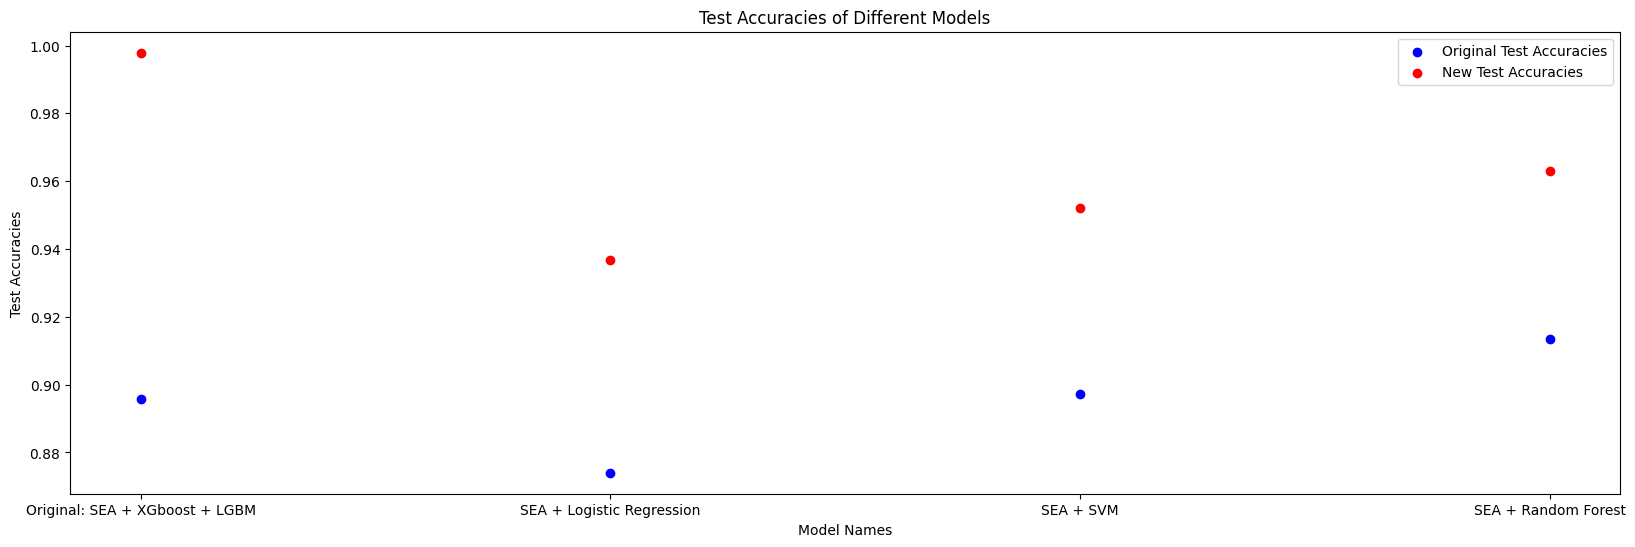

In [91]:
# Set the figure size
plt.figure(figsize=(20, 6))

# Create the original scatter plot
plt.scatter(model_names, test_accs, color='blue', label='Original Test Accuracies')

# Add the new data to the plot
plt.scatter(model_names, test_accs_new, color='red', label='New Test Accuracies')

# Add labels and title
plt.xlabel('Model Names')
plt.ylabel('Test Accuracies')
plt.title('Test Accuracies of Different Models')

# Add a legend to differentiate between the original and new data
plt.legend()

# Show the plot
plt.show()